# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Databricks : Cluster Creation </font>

### <font color='blue'> Databricks : Notebook Creation </font>

### <font color='blue'> HeartRate Data example : Problem Statement </font>

### <font color='blue'> HeartRate Data example : Sample data creation </font>

### <font color='blue'> HeartRate Data example : Solution </font>


In this week's notebook, we are going to explore batch procssing using pyspark. 

The platform that we are going to use for batch processing is Databricks. 

We are going to create the cluster on databricks and then we will create sample data. 

We will create a notebook within Databricks where we will use pyspark to create aggregate data, partitions and moving average of the collected data. 

Databricks runs standard Spark applications inside AWS, similar to EMR, but it adds a variety of features to create an end-to-end environment for working with Spark. 

These include:

    * Interactive UI (includes a workspace with notebooks, dashboards, a job scheduler, point-and-click cluster management)
    * Cluster sharing (multiple users can connect to the same cluster, saving cost)
    * Data management (support for connecting different data sources to Spark, caching service to speed up queries)

Spark deployments generally need to bring in multiple users, different types of jobs, etc, and we want to have these built-in. 

Databricks adds several features, such as allowing multiple users to run commands on the same cluster and running multiple versions of Spark. 

Because Databricks is also the team that initially built Spark, the service is very up to date and tightly integrated with the latest Spark features.

We'll be using the community edition which provide free but limited access to AWS resources, and takes care of all the internal configurations.



# <font color='blue'> Databricks : Cluster Creation </font>

Lets create the cluster for our task on databricks community edition. 

There is a video shared with our learners as an optional video along with week-7 video content. 

This video covers the login process and cluster creation on databricks. 

In this section we are going to create the first cluster and choose the appropriate `Databricks Runtime version`. 

For our example we have taken `7.4 (Scala 2.12, Spark 3.0.1)` of databricks version. 



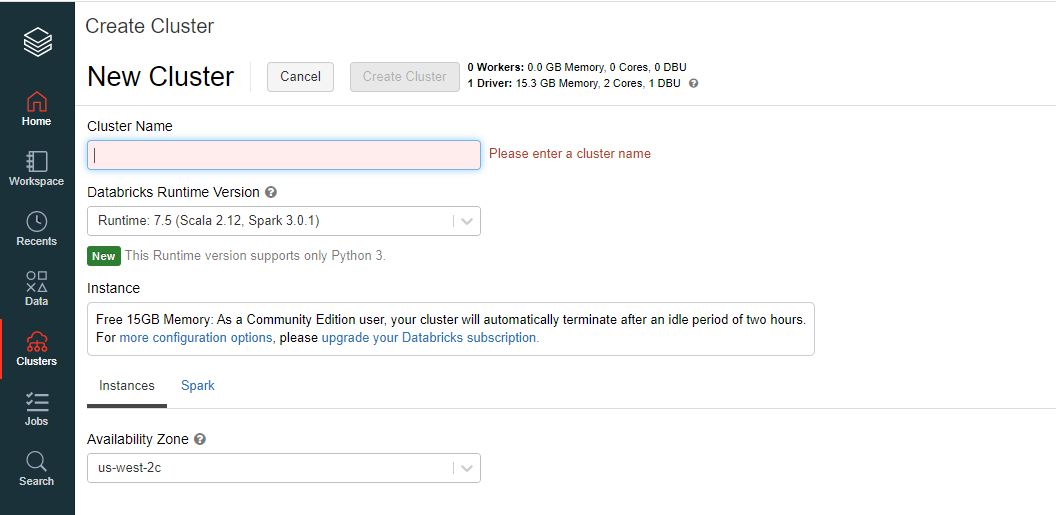



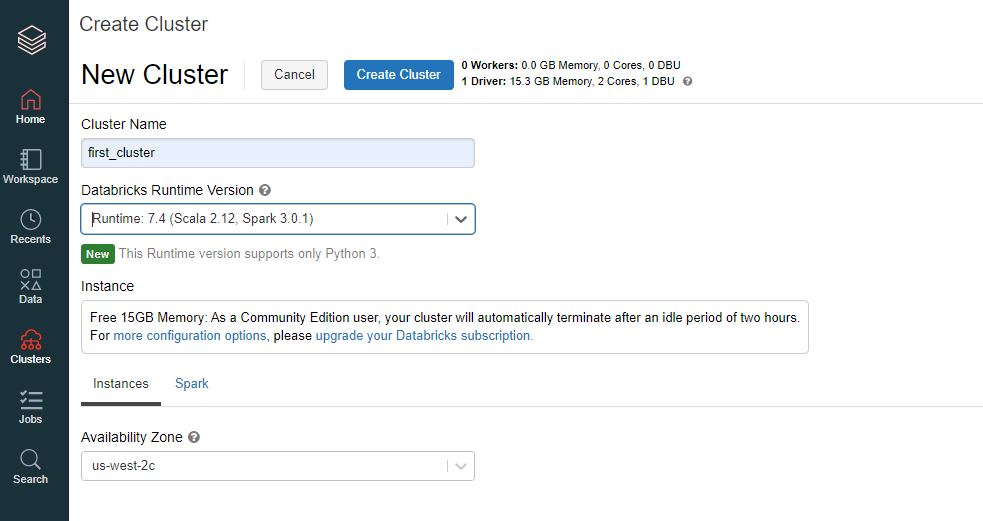
Click on create cluster after providing name and choosing version for your first cluster. 

# <font color='blue'> Databricks : Notebook Creation </font>

Cluster creation will take around 5-8 minutes. Once it is created successfully click on the `book logo` on left top corner. 

Now here the page will look something like this. 

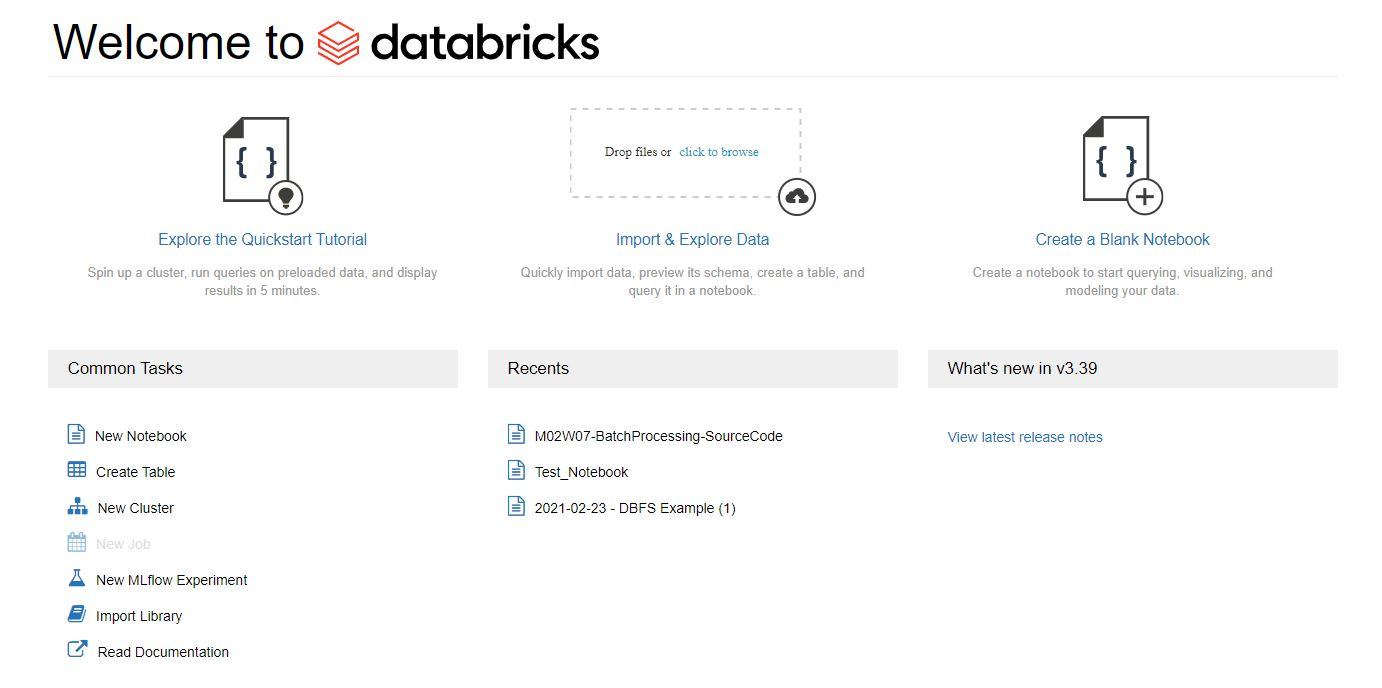

Click on create a blank notebook, a pop window will ask you to provide the name, choose language and cluster name. 

Provide the details and click on create, this will create the notebook and will look as mentioned below

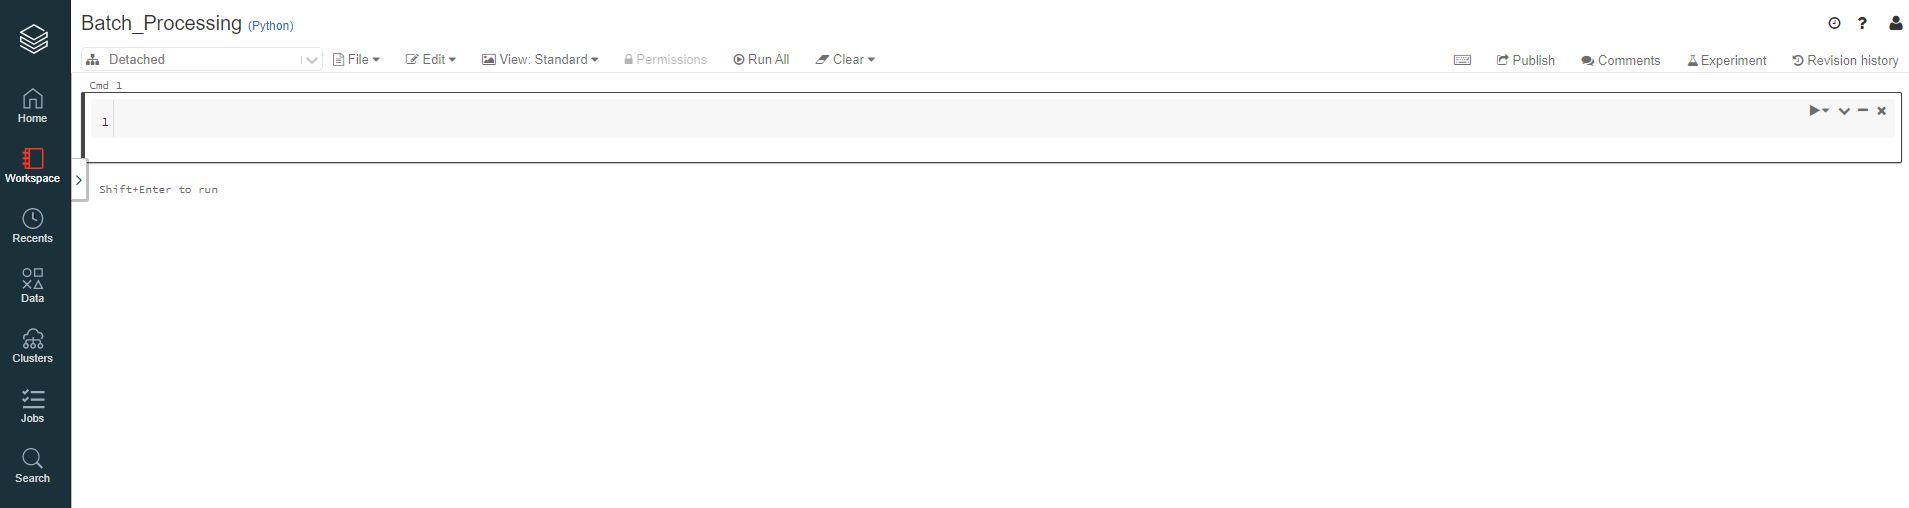

Currently there is no cluster is attached with the notebook. 

Click on the drop down menu where `detached` is mentioned and choose the newly created cluster. 

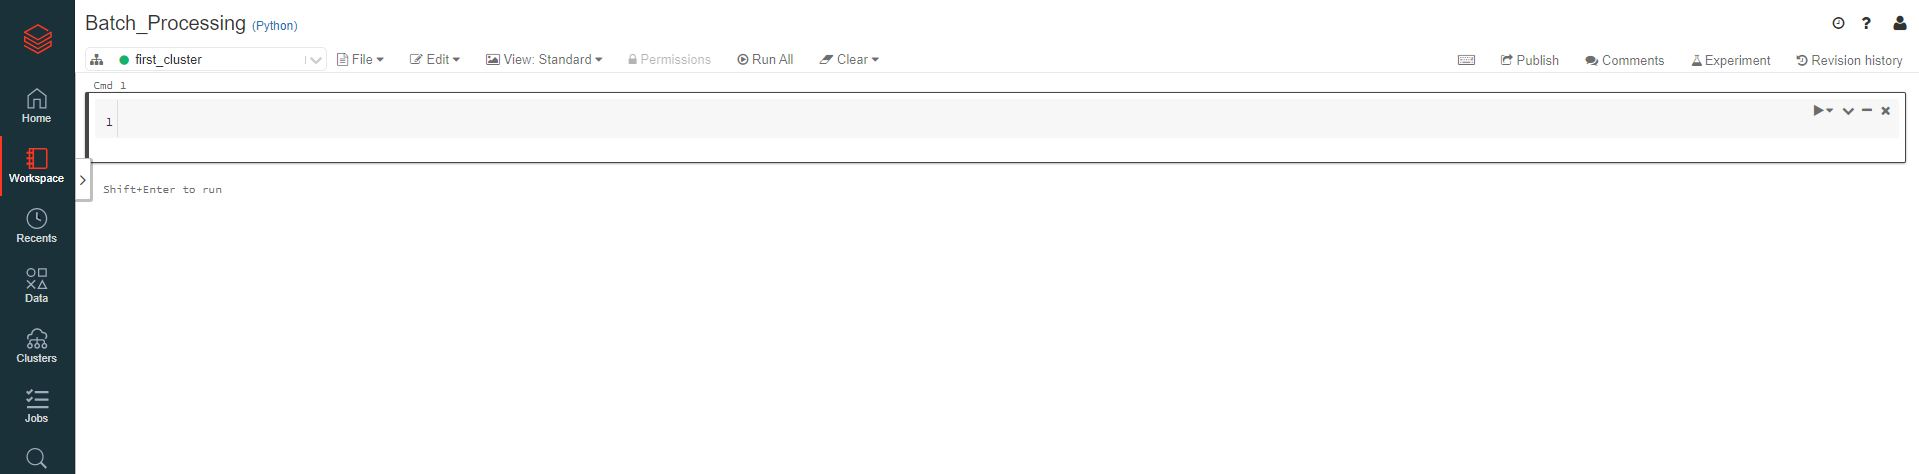



# <font color='blue'> HeartRate Data example : Problem Statement </font>

In this problem statement we are going to simulate data of heart rate readings for a week. 

Created data will have per minute information of heart rate readings. Data will be then used to create the aggregated information as mentioned below: 

* Create aggregated data by combining per minute data into 15 minute interval data. 
* Calculate the moving average of heart rate reading for every 15 minute. 



# <font color='blue'> Sample data creation </font>

In this section we are going to use a simple script which can be used to create the csv files for the heartrate readings. 

This script will create one csv file which will have per minute heart arte readngs for one week.



In [ ]:
import datetime
import csv
import random


def datetime_range(start, end, delta):
    current = start
    with open('HeartRateData01.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        count = 1
        writer.writerow(["SerialNo", "CurrentTime", "CurrentTS", "SubjectId", "HeartRate"])
        while current < end:
            value = int(random.normalvariate(85,12))
            yield current
            currentTS = current.timestamp()
            writer.writerow([count, current, currentTS, "S1098", value])
            current += delta
            count += 1

dts = [dt.strftime('%Y-%m-%d T%H:%M:%S Z') for dt in 
       datetime_range(datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2019, 9, 8, 0, 0), 
       datetime.timedelta(seconds=60))]


Execute the above mentioned script to create the sample HeartRate data. 

Once csv file is created, we need to upload the newly created file on the databricks. 

Go to the `home` page and click on import and explore data. It will take you to the following page:

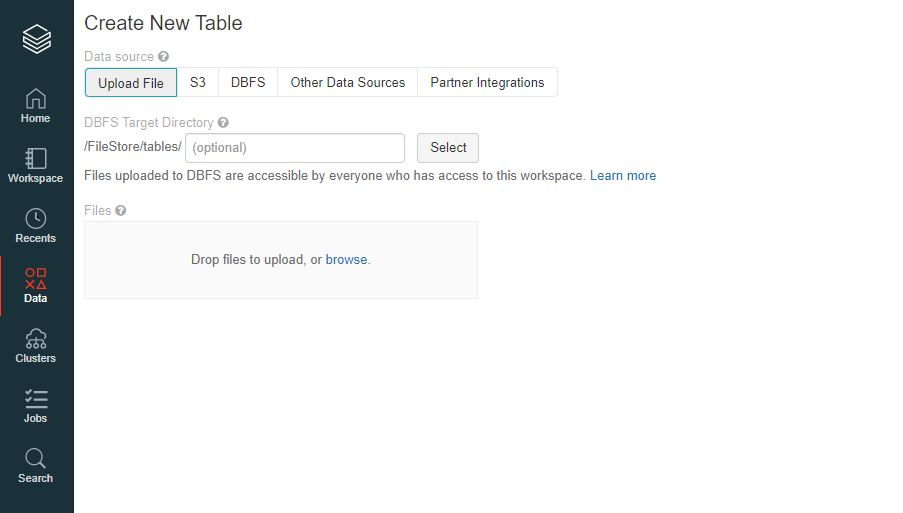



Click on browse and go to the directory where file is saved, and upload.

Once the file is uploaded, click on DBFS (Databricks File System) and choose the folder as mentioned below. 

By default your uploaded files are saved at a similar location to what's mentioned in the following image. 

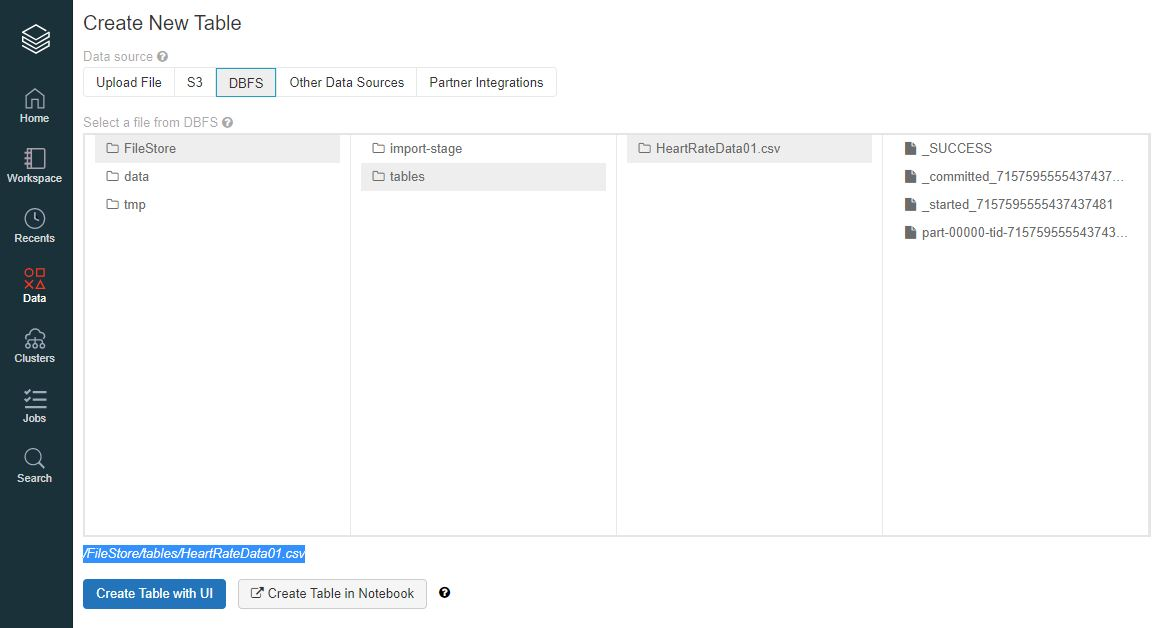

Highlighted path at the bottom of the image should be used to access the files in the code.  

# <font color='blue'> HeartRate Data example : Solution </font>

In [ ]:
%python
data = spark.read.csv("/FileStore/tables/HeartRateData01.csv", header="true", inferSchema="true")
data.cache() # Cache data for faster reuse
data = data.dropna() # drop rows with missing values
data.printSchema()

In the above cell uploaded csv file will be treated, cleansed and any empty row will be ropped from the dataframe. 

You can also view the Schema of the dataframe. 

In [ ]:
data.show(10)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import window

Above cell will import `functions` and `Window` and `window` methods from pyspark.sql module for our task. 


In [ ]:
w = Window.partitionBy('SubjectId').orderBy("CurrentTS").rangeBetween(-60*15, 0)
RollingAvgData = data.withColumn('RollingAverageHeartRate', F.avg('HeartRate').over(w))
RollingAvgData.show(20)

This cell will calculate the rolling average for 15 minute interval.

This means that for every upcoming minute, avearge HeartRate will keep on updating. 

What moving average means here: 

* With every upcoming minute average value will keep on getting updated. 
* Once it reaches the 15th Minute, average calculation will start considering the last 15 minutes, i.e. for 16th minute average will be calculated from (1-15) minute. 


In [ ]:
%python
RollingAvgData.createOrReplaceTempView("RollingAvg")

In [ ]:
%sql
select `RollingAverageHeartRate`, `CurrentTime` from RollingAvg

After executing the above command on databricks, choose the appropriate graph plotting option.  

In [ ]:
AverageHeartRate =  data.groupBy("SubjectId", "CurrentTime", window("CurrentTime", "15 minutes")).avg("HeartRate")
AverageHeartRate.select(AverageHeartRate.window.start.cast("string").alias("StartInterval"), AverageHeartRate.window.end.cast("string").alias("EndInterval"), "avg(HeartRate)").collect()
AverageHeartRate.take(10)

In this cell we are aggregatig the data for 15 minute interval to calculate the average. 

It means that every row in newly created dataframe has aggregated Average HeartRate for that interval. 


In [ ]:
%python
AverageHeartRate.createOrReplaceTempView("AggregatedHeartRate")

In [ ]:
%sql
select `avg(HeartRate)`, `CurrentTime` from AggregatedHeartRate

After executing the above command on databricks, choose the appropriate graph plotting option.  